# NLP 2024
# Lab 1: Classification models: Detecting hate speech

The rise of social media has allowed the expression of opinions
about debatable topics. X (ex Twitter) has emerged as a strong channel of communication to gather and disseminate news, to forecast outcome of elections and to exchange political events and discussions. It has also become an  important analytical tool for crime forecasting, tracking terrorist activities and detecting hate speech.

Hate speech is commonly defined as "any message that mocks
or discriminates against a person or group based on specific
characteristics such as color, ethnicity, gender, sexual orientation, nationality, religion, or other characteristics". The
amount of hate speech is steadily increasing due to X's
popularity and the resulting big data from user-generated content.

While NLP presents a promising approach to measure, detect and fight hate speech, that sounds more easy than it is. First of all, think about all the challenges that come with language evolution and language use in practice (e.g. sarcasm, slang, cultural variations) in understanding the true intent behind text. Moreover, there is an active discussion on what exactly consitutes hate speech from a legal perspective. Read more on this [here](https://aclanthology.org/2022.nllp-1.5.pdf).

In this lab, we will explore the linguistic, technical and ethical spects of treating hate speech identification as a NLP classification task.

By the end of this lab you should be able to:
- Implement and/or use built-in functions to preprocess your data
- Implement simple classification pipelines
- Import and use `huggingface datasets` library
- Import and use functions from `sklearn`
- Evaluate classification results
- Assess the difficulty of specific NLP tasks and propose solutions
- Reflect on the ethical dimensions that a NLP model can have

### Score breakdown

Exercise | Points
--- | ---
[Exercise 1](#e1) | 7
[Exercise 2](#e2) | 2
[Exercise 3](#e3) | 2
[Exercise 4](#e4) | 2
[Exercise 5](#e5) | 5
[Exercise 6](#e6) | 4
[Exercise 7](#e7) | 5
[Exercise 8](#e8) | 5
[Exercise 9](#e9) | 5
[Exercise 10](#e10) | 10
[Exercise 11](#e11) | 3
[Exercise 12](#e12) | 10
[Exercise 13](#e13) | 5
[Exercise 14](#e14) | 10
[Exercise 15](#e15) | 10
[Exercise 16](#e16) | 10
[Exercise 17](#e17) | 5
Total | 100

This score will be scaled down to 1 and that will be your final lab score.

### Instructions for delivery (Deadline: 6/May late night, wildcards possible)

+ Make sure that you include a proper amount/mix of comments, results and code.
+ In the end, make sure that all cells are executed properly and everything you need to show is in your (execucted) notebook.
+ You are asked to deliver only your executed notebook file, .ipnyb and nothing else. Enjoy!
+ Honor code applies to these tasks. Only individual work should be submitted.
+ While you may talk with others about this lab, we ask that you write your solutions individually. If you do discuss specific tasks with others please include their names below.
+ It is mandatory to list and disclose any website (or other resource) you used (e.g. stackoverflow) as well as any genAI tools (e.g. chatGPT) used.

Collaborators: list collaborators here

**I talked with Jerry about...**

Use of genAI tools (e.g. chatGPT), websites (e.g. stackoverflow): list websites where you found code (or other info) as well as include information on how you used genAI tools (e.g. prompts):

I asked chatGPT about...

## Outline
- [0 Setup](#0)
- [1: Load Dataset](#1)
- [2: Preprocess Dataset](#2)
  - [Exercise 1](#e1)
- [3: Build Vocabulary](#3)
  - [Exercise 2](#e2)
  - [Exercise 3](#e3)
  - [Exercise 4](#e4)
  - [Exercise 5](#e5)
  - [Exercise 6](#e6)
- [4: Build Handcrafted Classifier](43)
  - [Exercise 7](#e7)
  - [Exercise 8](#e8)
- [5: Build Bag-of-Words](#5)
  - [Exercise 9](#e9)
- [6: Bag-of-Words with Naive Bayes](#6)
  - [Exercise 10](#e10)
- [7: Bag-of-Words with Logistic Regression](#7)
  - [Exercise 11](#e11)
  - [Exercise 12](#e12)
- [8: TF-IDF](#8)
  - [Exercise 13](#e13)
  - [Exercise 14](#e14)
- [9: Adding Handcrafted Features](#9)
  - [Exercise 15](#e15)
  - [Exercise 16](#e16)
- [10: Reflection, Bias, Fairness, Ethics](#10)
  - [Exercise 17](#e17)


<a name='0'></a>
## 0. Setup

We will be using huggingface datasets library ([https://huggingface.co/datasets](https://huggingface.co/datasets)). You can find the detailed documentation and tutorials here: [https://huggingface.co/docs/datasets/en/index](https://huggingface.co/docs/datasets/en/index)

If you don't have it installed you can run the code below:

In [1]:
! pip install -U datasets~=2.18.0

We will also need those packages, so let's import them now!

In [2]:
from collections import Counter
import re    # for regular expressions
from string import punctuation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datasets

<a name='1'></a>
## 1. Load Dataset

We will be using "tweet_eval" dataset and specifically the hate speech subset. You can find more info on how this dataset has been created in the following papers [[1](https://aclanthology.org/S19-2007.pdf)],[[2](https://aclanthology.org/2020.findings-emnlp.148.pdf)]. The dataset contains tweets from 2018 and the goal is to identify whether a tweet is hateful or not against any of the two target communities: immigrants and women. Make sure to read and reflect on how annotation was performed, since this can give you some insights on the modeling.

In order to load a dataset simply call ```load_dataset``` function specifying the dataset name. You can find many more datasets at the huggingface website.

In [3]:
tweet_ds = datasets.load_dataset('tweet_eval', 'hate')
print(tweet_ds)

# this will make the dataset return the values as numpy arrays
tweet_ds = tweet_ds.with_format("np")

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2970
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})


The loaded dataset contains three subsets ("train", "validation", and "test"). Each consists of two columns: "text" and "label". Label of 0 means "non-hate" and label of 1 means "hate" We can access them like so:

In [4]:
for i in range(8):
    print(tweet_ds['train'][i])

{'text': '@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…', 'label': 0}
{'text': 'A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎', 'label': 1}
{'text': '@user @user real talk do you have eyes or were they gouged out by a rapefugee?', 'label': 1}
{'text': 'your girlfriend lookin at me like a groupie in this bitch!', 'label': 1}
{'text': 'Hysterical woman like @user', 'label': 0}
{'text': 'Me flirting- So tell me about your father...', 'label': 0}
{'text': 'The Philippine Catholic bishops\' work for migrant workers should focus on families who are "paying the great...', 'label': 0}
{'text': "I AM NOT GOING AFTER YOUR EX BF YOU LIEING SACK OF SHIT ! I'm done with you dude that's why I dumped your ass cause your a lieing 😂😡 bitch", 'label': 1}


<font color='red'>

as part of the dataset inspection, it might be helpful to help them extract it and actually see all data points

</font>

You can easily cast the dataset to the pandas DataFrame. We will do that below to plot the balance of the labels.

<Axes: xlabel='label'>

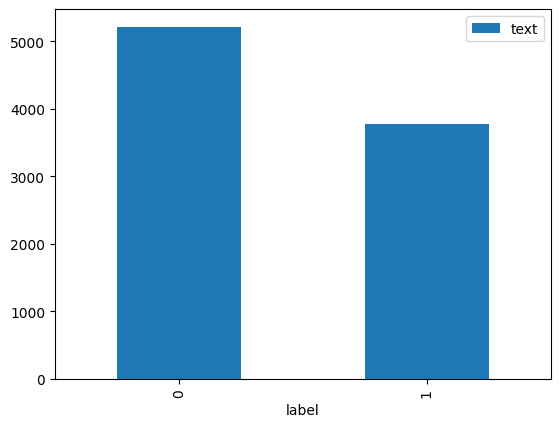

In [5]:
pd.DataFrame(tweet_ds['train']).groupby('label').count().plot.bar()

We can filter the examples based on the label. We will use ```filter()``` method. See this link for more details [https://huggingface.co/docs/datasets/en/use_dataset](https://huggingface.co/docs/datasets/en/use_dataset).

In [6]:
no_hate = tweet_ds['train'].filter(lambda e: e['label'] == 0)
for i in range(8):
    print(no_hate[i])

{'text': '@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…', 'label': 0}
{'text': 'Hysterical woman like @user', 'label': 0}
{'text': 'Me flirting- So tell me about your father...', 'label': 0}
{'text': 'The Philippine Catholic bishops\' work for migrant workers should focus on families who are "paying the great...', 'label': 0}
{'text': 'When cuffin season is finally over', 'label': 0}
{'text': "Only that in you which is me can hear what I'm saying. ~Baba Ram Dass", 'label': 0}
{'text': 'More migrants take sea route to #Spain than Italy this year: UN', 'label': 0}
{'text': 'Essential reading for those in Scribner, Nebraska who are considering an anti-immigrant ballot measure.', 'label': 0}


Let's use the ```filter()``` method to remove empty entries.

In [7]:
tweet_ds = tweet_ds.filter(lambda e: e['text'] != '' and e['text'] is not None)
print(tweet_ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8993
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2970
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 999
    })
})


<a name='2'></a>
## 2. Preprocess Dataset

In this section we will preprocess the dataset by cleaning and tokenizing the entries. You will use the knowledge and skills from the previous lab.

Datasets library contains a very useful method ```map```. It expects a function that will receive an example from the dataset. This function will be applied to all entries.

<a name='e1'></a>
### Exercise 1 (points 7)

Fill in the function in order to clean the examples. We already provide some pre-processing (e.g. turn text to a lower case) and some regular expressions to handle some punctuation special cases, however the goal is for you to implement your own operations. You might want to inspect the dataset (e.g. check several data points) before you implement this method and also you might need to revisit it after you have seen the first classification results. For every operation, try to also include the intuition behind it (unless it's obvious).

There is no exclusive list of pre-processing you need to have (since many decisions will depend on your observations). Try to include different examples of handling different language issues with specific regular expressions or other pre-processing decisions.

In [8]:
def clean(example):
    """
    Cleans the example from the Dataset
    Args:
        example: an example from the Dataset

    Returns: update example containing 'clean' column

    """
    text = example['text']

    # Empty text
    if type(text) not in (str, np.str_) or text=='':
        example['clean'] = ''
        return example

    # 'text' from the example can be of type numpy.str_, let's convert it to a python str
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)

    #you might need more
    #add them here

    ### YOUR CODE HERE

    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[^\s]+', '', text)
    
    text = re.sub(r'#[^\s]+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)    
    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub("\'ll", " will ", text)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'m", " am ", text)
    text = re.sub("n\'t", " not ", text)

    text = re.sub(" lol ", ' laugh out loud ', text, flags=re.IGNORECASE)
    text = re.sub(" brb ", ' be right back ', text, flags=re.IGNORECASE)
    text = re.sub(" btw ", ' by the way ', text, flags=re.IGNORECASE)
    text = re.sub(" omg ", ' oh my god ', text, flags=re.IGNORECASE)
    text = re.sub(" wtf ", ' what the fuck ', text, flags=re.IGNORECASE)
    text = re.sub(" idk ", ' I don\'t know ', text, flags=re.IGNORECASE)
    text = re.sub(" imo ", ' in my opinion ', text, flags=re.IGNORECASE)
    text = re.sub(" rofl ", ' rolling on the floor laughing ', text, flags=re.IGNORECASE)
    text = re.sub(" ttyl ", ' talk to you later ', text, flags=re.IGNORECASE)
    text = re.sub(" gtg ", ' got to go ', text, flags=re.IGNORECASE)
    text = re.sub(" omw ", ' on my way ', text, flags=re.IGNORECASE)
    text = re.sub(" fwiw ", ' for what it\'s worth ', text, flags=re.IGNORECASE)
    text = re.sub(" afaik ", ' as far as I know ', text, flags=re.IGNORECASE)
    text = re.sub(" irl ", ' in real life ', text, flags=re.IGNORECASE)
    text = re.sub(" np ", ' no problem ', text, flags=re.IGNORECASE)
    text = re.sub(" rt ", ' retweet ', text, flags=re.IGNORECASE)
    text = re.sub(" smh ", ' shaking my head ', text, flags=re.IGNORECASE)
    text = re.sub(" tbt ", ' throwback thursday ', text, flags=re.IGNORECASE)
    text = re.sub(" tyt ", ' take your time ', text, flags=re.IGNORECASE)
    text = re.sub(" icymi ", ' in case you missed it ', text, flags=re.IGNORECASE)
    text = re.sub(" yolo ", ' you only live once ', text, flags=re.IGNORECASE)
    
    # Tokenization






    ### YOUR CODE ENDS HERE

    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)

    # Update the example with the cleaned text
    example['clean'] = text.strip()
    return example

This is an example of applying the ```clean()``` function you just wrote to a single entry of the dataset. The function added a 'clean' field to the example.

In [9]:
print(tweet_ds['train'][10])
print(clean(tweet_ds['train'][10]))

{'text': 'Cory Booker and Kamala Harris competing for Most Hysterical Woman at the Kavanaugh hearings, Coulter hilariously tweeted.And yes, liberals immediately got triggered on Twitter, saying her joke was offensive. To them we say, suck it up, snowflakes.', 'label': 1}
{'text': 'Cory Booker and Kamala Harris competing for Most Hysterical Woman at the Kavanaugh hearings, Coulter hilariously tweeted.And yes, liberals immediately got triggered on Twitter, saying her joke was offensive. To them we say, suck it up, snowflakes.', 'label': 1, 'clean': 'cory booker and kamala harris competing for most hysterical woman at the kavanaugh hearings coulter hilariously tweetedand yes liberals immediately got triggered on twitter saying her joke was offensive to them we say suck it up snowflakes'}


Let's finally use the ```map()``` method and apply your `clean()` function to all entries of the dataset. You can see that the ```clean``` column has been added to each split.

In [10]:
tweet_ds = tweet_ds.map(clean)
print(tweet_ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'clean'],
        num_rows: 8993
    })
    test: Dataset({
        features: ['text', 'label', 'clean'],
        num_rows: 2970
    })
    validation: Dataset({
        features: ['text', 'label', 'clean'],
        num_rows: 999
    })
})


<a name='3'></a>
## 3. Build Vocabulary

Feature engineering is when NLP task-specific knowledge comes in handy, and make it more likely for a simple classifier to learn the task. This requires us to index tokens and create meaningful representations out of them.

Firstm we have to create a vocabulary. In the previous section, we implemeneted the tokenization and the cleaning.

In this section we will start by building the vocabulary for your dataset (aka the number of different words in the corpus). We will build it based on the cleaned text of the `train` split. We will investigate some properties of corpora (e.g. Zipf's law, most common words for hate speech language).



<a name='e2'></a>
### Exercise 2 (points 2)

Fill in the following function so that the ```Counter``` is returned containing all words of a sentence with the number of occurrences. Check the documentation if needed [https://docs.python.org/3/library/collections.html#collections.Counter](https://docs.python.org/3/library/collections.html#collections.Counter)

In [11]:
def get_bag_of_words(sentence):
    """
    Tokenizes the sentence into separate words.
    Args:
        sentence: string containing a sentence

    Returns: Counter of the tokens of the input sentence

    """
    ### YOUR CODE HERE
    tokens = sentence.split()
    word_counts = Counter(tokens)
    return word_counts
    ### YOUR CODE ENDS HERE


Let's test the function you just wrote:

In [12]:
sentence = tweet_ds['train'][0]['clean']
print(sentence)

sentence_bow = get_bag_of_words(sentence)
print(sentence_bow)

nice new signage are you not concerned by beatlemania style hysterical crowds crongregating on you
Counter({'you': 2, 'nice': 1, 'new': 1, 'signage': 1, 'are': 1, 'not': 1, 'concerned': 1, 'by': 1, 'beatlemania': 1, 'style': 1, 'hysterical': 1, 'crowds': 1, 'crongregating': 1, 'on': 1})


We will also be interested in the word count of the whole dataset (or it's subset). The next function will combine word counts specified as a list into a single Counter.

<a name='e3'></a>
### Exercise 3 (points 2)

Fill in the following function to return a counter combining the provided list of counters. If the word is present in multiple counters the result should sum all the occurrences.

In [13]:
def aggregate_bags_of_words(bags_of_words):
    """
    Aggregates the provided list containing bags-of-words
    Args:
        bags_of_words: list of Counters

    Returns: Counter of the tokens of all bags-of-words

    """
       # Initialize an empty Counter to aggregate the tokens
    aggregated_bag = Counter()

    # Iterate over each bag of words
    for bag in bags_of_words:
        # Update the aggregated bag with the counts from the current bag
        aggregated_bag.update(bag)

    # Return the aggregated bag
    return aggregated_bag
    ### YOUR CODE ENDS HERE

The next function will calculate word counts of each cleaned sentence of the dataset split and then combine them into a single Counter.

<a name='e4'></a>
### Exercise 4 (points 2)

Fill in the following function to obtain the counter representing the whole dataset. Use the function ```aggregate_bags_of_words()``` you implemented in the previous exercise.

In [14]:
from collections import Counter

def get_dataset_word_count(dataset_split):
    """
    Creates a word count (a Counter) for the dataset split.
    Args:
        dataset_split: a dataset split

    Returns: Counter of the tokens of the whole split

    """
    temp = []
    for i in range(len(dataset_split)):
        temp.append(get_bag_of_words(dataset_split[i]['clean']))

    return aggregate_bags_of_words(temp)

Here are the word counts of the `train` and `validation` subsets.

In [15]:
train_word_count = get_dataset_word_count(tweet_ds['train'])
validation_word_count = get_dataset_word_count(tweet_ds['validation'])

Let us explore them a bit more

In [16]:
print(f'train word count: {len(train_word_count)}')
print('Most common words:')
print(train_word_count.most_common(8))

print('Least common words:')
print(train_word_count.most_common()[-8:])

print(f'validation word count: {len(validation_word_count)}')
print(validation_word_count.most_common(10))

print('Most common words:')
print(validation_word_count.most_common(8))

print('Least common words:')
print(validation_word_count.most_common()[-8:])

train word count: 16173
Most common words:
[('the', 5504), ('to', 4783), ('a', 3923), ('you', 3361), ('and', 3202), ('of', 2877), ('in', 2560), ('is', 2051)]
Least common words:
[('gangbang', 1), ('leaf', 1), ('generalshame', 1), ('happiest', 1), ('birthdays', 1), ('oooohhhh', 1), ('kennedys', 1), ('picwhy', 1)]
validation word count: 4716
[('the', 758), ('to', 613), ('you', 518), ('a', 498), ('and', 420), ('of', 349), ('in', 330), ('is', 267), ('i', 226), ('that', 199)]
Most common words:
[('the', 758), ('to', 613), ('you', 518), ('a', 498), ('and', 420), ('of', 349), ('in', 330), ('is', 267)]
Least common words:
[('voting', 1), ('learned', 1), ('independence', 1), ('infeuenc', 1), ('scale', 1), ('delhihawkers', 1), ('menaceillegal', 1), ('constructionsappeasement', 1)]


We can also plot the counts of the words. You can check the [Power law](https://en.wikipedia.org/wiki/Power_law) if you are more interested.

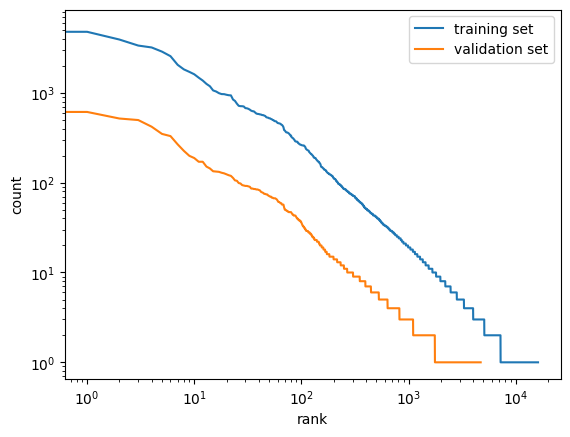

In [17]:
plt.loglog([val for word,val in train_word_count.most_common()])
plt.loglog([val for word,val in validation_word_count.most_common()])
plt.xlabel('rank')
plt.ylabel('count')
plt.legend(['training set','validation set']);

Now let's look at the sentences that are marked as hate and non-hate. We can use the method ```filter``` to get two datasets containing only the sentences labeled the same.

In [18]:
non_hate_ds = tweet_ds['train'].filter(lambda ex: ex['label'] == 0)
hate_ds = tweet_ds['train'].filter(lambda ex: ex['label'] == 1)

non_hate_word_count = get_dataset_word_count(non_hate_ds)
hate_word_count = get_dataset_word_count(hate_ds)

Are there any words that are present in one but not in the other?


<a name='e5'></a>
### Exercise 5 (points 5)

Fill in the following function to return (a Counter of) words that are not in the provided vocabulary. The vocabulary is in the form of a list of words.

In [19]:
def get_oov_word_count(word_count, vocab):
    """
    Finds the words that are not in the provided vocabulary.
    Args:
        word_count: Counter of the words
        vocab: a list of words in the vocabulary

    Returns: a Counter of the words that are outside the vocabulary

    """
    ### YOUR CODE HERE
    oov_words = Counter()
    for word, count in word_count.items():
        if word not in vocab:
            oov_words[word] = count
    return oov_words

    ### YOUR CODE ENDS HERE

In [20]:
non_hate_only_word_count = get_oov_word_count(non_hate_word_count, hate_word_count.keys())
hate_only_word_count = get_oov_word_count(hate_word_count, non_hate_word_count.keys())

print(f'only non-hate word count: {len(non_hate_only_word_count)}')
print(f'only hate word count: {len(hate_only_word_count)}')

print('Most common non-hate words:')
print(non_hate_only_word_count.most_common(10))

print('Most common hate words:')
print(hate_only_word_count.most_common(10))

only non-hate word count: 6998
only hate word count: 4050
Most common non-hate words:
[('catholic', 19), ('palestinian', 18), ('blog', 18), ('rebuild', 17), ('advertising', 14), ('classes', 14), ('film', 12), ('sessions', 12), ('separating', 12), ('online', 12)]
Most common hate words:
[('cheated', 9), ('africans', 8), ('hystericalyoure', 8), ('dreamer', 7), ('lazy', 7), ('invaded', 6), ('overpopulation', 6), ('fame', 6), ('drivers', 6), ('michelle', 6)]


Often some words are used rarely in a specific context. We can remove them based on a threshold (a minimum number of occurrences that are required to keep the word in).



<a name='e6'></a>
### Exercise 6 (points 4)

Fill in the following function.

In [21]:
def prune_word_count(word_count, threshold):
    """
    Removes words from the word counter that occur less than the specified threshold
    Args:
        word_count: Counter with the word counts
        threshold: a minimum number of occurrences

    Returns: a Counter with frequent words

    """
    ### YOUR CODE HERE

    pruned_word_count = Counter({word: count for word, count in word_count.items() if count >= threshold})
    return pruned_word_count


    ### YOUR CODE ENDS HERE

In [22]:
pruned_word_count = prune_word_count(train_word_count, 4)

In [23]:
print(f'train word count: {len(train_word_count)}')
print(f'pruned word count: {len(pruned_word_count)}')

print('Most common words:')
print(pruned_word_count.most_common(8))

print('Least common words:')
print(pruned_word_count.most_common()[-8:])

train word count: 16173
pruned word count: 4006
Most common words:
[('the', 5504), ('to', 4783), ('a', 3923), ('you', 3361), ('and', 3202), ('of', 2877), ('in', 2560), ('is', 2051)]
Least common words:
[('harper', 4), ('I', 4), ("don't", 4), ('ms', 4), ('nerve', 4), ('jungle', 4), ('updates', 4), ('complex', 4)]


Now (finally) we will construct a vocabulary. It will be a list of words (sorted alphabetically) that are present in the pruned word counter of the training subset.

In [24]:
vocab = sorted(pruned_word_count.keys())
vocab_size = len(vocab)
print(f'Vocab size: {vocab_size}')
print(vocab[:10])

Vocab size: 4006
['0', '1', '10', '100', '10000', '100000', '11', '12', '13', '135']


<a name='4'></a>
## 4. Build a Handcrafted Classifier

Recall from the lectures that a classification model, is practically a function that maps the input text to the output classes. In our case, the output classes are 2: non-hate (return ```0```) or hate (return ```1```). In this section, we will build such a function, based on a rule-based system.


<a name='e7'></a>
### Exercise 7 (points 5)

In order to device such simple classification rules, we will use analysis we conducted previously about which words are frequent in which class (i.e. non-hate vs. hate). Try to figure out an algorithm (based on if-else statements, aka rules) that would detect hate speech. Code the algorithm in the following function. You should not try to be exhaustive here and come up with the perfect rules (we are not sure they exist) but it's important to reflect (at the next exercise) on the trade-offs of implementing a rule-based classifier.

In [25]:
def detect_hate(text):
  bow = get_bag_of_words(text)

  ### YOUR CODE HERE

  if 'whore' in bow or 'kill' in bow or '#buildthatwall' in bow or 'slut' in bow or 'nigger' in bow or 'nigga' in bow or 'faggot' in bow or 'cuck' in bow or 'retard' in bow or 'terrorist' in bow or 'hoe' in bow or 'hoes' in bow or 'ban' in bow or 'banned' in bow :
    return 1                                                      
  else:                                                         
    return 0      

  ### YOUR CODE ENDS HERE


The next code block will apply your function to the dataset to obtain the predictions.

In [26]:
def apply_hate_speech_detector(example):
  text = example['clean']
  predicted_label = detect_hate(text)
  example['predicted_label'] = predicted_label
  return example

# apply the function to all examples
predictions = tweet_ds.map(apply_hate_speech_detector)
# remove columns other than 'predicted_label'
predictions = predictions.remove_columns(tweet_ds['train'].column_names)

Here we create a small function to print the F1 score for predictions of the model. We will use it shortly.

In [27]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

def print_scores(y, prediction, report=False):
    print('f1:', f1_score(y, prediction, average='macro'))
    if report:
        print(classification_report(y, prediction))

Let's retrieve the predictions for each subset (train, validation, test).

In [28]:
print(predictions)

train_prediction = predictions['train']['predicted_label']
y_train = tweet_ds['train']['label']
print('train')
print(train_prediction.shape)
print(y_train.shape)

valid_prediction = predictions['validation']['predicted_label']
y_valid = tweet_ds['validation']['label']
print('valid')
print(valid_prediction.shape)
print(y_valid.shape)

test_prediction = predictions['test']['predicted_label']
y_test = tweet_ds['test']['label']
print('test')
print(test_prediction.shape)
print(y_test.shape)


DatasetDict({
    train: Dataset({
        features: ['predicted_label'],
        num_rows: 8993
    })
    test: Dataset({
        features: ['predicted_label'],
        num_rows: 2970
    })
    validation: Dataset({
        features: ['predicted_label'],
        num_rows: 999
    })
})
train
(8993,)
(8993,)
valid
(999,)
(999,)
test
(2970,)
(2970,)


Here we will print the F1 scores of your predictions for each subset.

In [29]:
print('training score:')
print_scores(y_train, train_prediction)
print('validation score:')
print_scores(y_valid, valid_prediction, report=True)
print('test score:')
print_scores(y_test, test_prediction, report=True)

training score:
f1: 0.498407900391982
validation score:
f1: 0.4871779487117949
              precision    recall  f1-score   support

           0       0.60      0.97      0.74       572
           1       0.78      0.14      0.23       427

    accuracy                           0.61       999
   macro avg       0.69      0.55      0.49       999
weighted avg       0.68      0.61      0.52       999

test score:
f1: 0.5915586001687614
              precision    recall  f1-score   support

           0       0.64      0.82      0.72      1718
           1       0.60      0.37      0.46      1252

    accuracy                           0.63      2970
   macro avg       0.62      0.60      0.59      2970
weighted avg       0.63      0.63      0.61      2970



Let us also look at some examples with their predictions.

In [30]:
for i in range(10):
    example = tweet_ds['test'][i]
    print(example['text'])
    print(f'Predicted label: {test_prediction[i]}')
    print(f'True label: {y_test[i]}')
    print()

@user , you are correct that Reid certainly is a weasel. Sadly, we've got our own weasels; @user Sen McConnell & @user .The corrupt Mueller investigation w/be STOPPED if those 3 did their jobs.#MAGA #KAG #POTUS #Trump #NEWS #VoteRed #NoDACA #USA
Predicted label: 0
True label: 0

Whoever just unfollowed me you a bitch
Predicted label: 0
True label: 1

@user @user Those People Invaded Us!!! They DO NOT BELING HERE & HAVE NO RIGHTS! Its #AmericaFIRST! Open Your House To Them If Your That IGNORANT! & Yes Im A #Christian Too! #NODACA!
Predicted label: 0
True label: 1

stop JUDGING bitches by there cover, jus cuz she bad don't mean she's a catch shawdy could be a whore 👀 das opposite of a keeper
Predicted label: 1
True label: 1

how about i knock heads off and send them gift wrapped to your moms house you dumb raggedy bird bitch ass hoes
Predicted label: 1
True label: 1

@user @user @user Always #NoDACA.I AM BORN IN #USA AND #USA FIRST.
Predicted label: 0
True label: 0

@user friends ? that'

<a name='e8'></a>
### Exercise 8 (points 5)

In this section, discuss the results you obtained. Potentially, try to improve your algorithm based on the results (e.g. do you have many false positives? or false negatives?). Make sure to comment on the trade-offs of such a simplified system.

The test and validation scores of this algorithm seem to be very similar. That is a good sign, as it demonstrates consistency.
Initially, I made an error with the if statement initially, which meant that everything was classified as hate-speech. It was interesting that the accuracy rates were higher with that. But this situation was also resulting in a lot of false negatives. The recall rates in the validation set seem to yield odd results. WIth one closing in on 1 and the other to 0. This is not observeed in the test set. 

With hate-speech sentimental analysis, it is important to realise that that words need to be taken in context. For example, the word 'bitch' can be used in both ways. This might be a direct consequence of use of slang. Furthermore, words are not in their vector form. Which means 'hoe' and 'hoeing' would be treat differently. Also, with the use of Hashtags, the words are often compressed with no use of space. To improve the model, one can also take into account more words that would be indicative of hate-speech. This algorithm takes very limited words which popped up at the top of my head. 

I searched up some strategies via chatGPT and I came across a ranking system to work with contexts. It might make sense to take negations into account but it is difficult to work with in such a simplistic model. The ranking system would cancel the use of hate words if negation was found in a sentence. This technique would most importantly help us get rid of false positives/negatives. However, if implemented incorrectly, they could turn over the entire model. 

It is also essential that we take into account with that the bias of the programmer into account. One may consider certain political statements to be hate speech while the other may agree with them. This might make it difficult. This is why we must either work in teams or trust the developer to limit their biases. 

<a name='5'></a>
## 5. Build Bag-of-Words

Having a vocabulary is important for indexing every word in our corpus.
To represent a document as a vector however, we need more than just indexing, such as a vector space that represents the words:

* Bag-of-Words model: A single document can be considered as a bag of words and how many times each word occured, without caring about the order of the words. The word occurence counting is also called term frequency. You can think if this as a vector over all of the vocabulary where the entries are how many times that term has occured.

* TF-IDF: term frequency–inverse document frequency diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.

<a name='e9'></a>
### Exercise 9 (points 5)

Let us build the bag-of-words for the whole dataset. We will only include the words that are present in our vocabulary that we created in the previous section. Words that are missing from the vocabulary will be replaced with the <unknown> token. For training we need to convert the counter into a numpy array [https://numpy.org/doc/stable/reference/generated/numpy.array.html](https://numpy.org/doc/stable/reference/generated/numpy.array.html). The array will be of the size of the vocabulary (plus 1 for the <unknown> token). Each element will correspond to the word in our vocabulary and contain the number of occurrences of this word in a particular sentence. Fill in the following function.

In [31]:
def calculate_bag_of_words(example):
    """
    Calculates the word count and encodes it as a numpy array of the size equal to the vocab
    Args:
        example: an example from the Dataset

    Returns: updated example with 'bow' column

    """
    text = example['clean']
    bow = get_bag_of_words(text)
    # create numpy array with the size of the vocab plus 1 for the unknown token
    bow_numpy = np.zeros((vocab_size + 1), dtype=int)

    ### YOUR CODE HERE

    for word, count in bow.items():
        if word in vocab:
            bow_numpy[vocab.index(word)] = count
        else:
            bow_numpy[vocab_size] += count

    ### YOUR CODE ENDS HERE
    example['bow'] = bow_numpy
    return example

In [32]:
print(calculate_bag_of_words(tweet_ds['train'][0]))

{'text': '@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…', 'label': 0, 'clean': 'nice new signage are you not concerned by beatlemania style hysterical crowds crongregating on you', 'bow': array([0, 0, 0, ..., 0, 0, 4])}


In [33]:
tweet_ds = tweet_ds.map(calculate_bag_of_words)

print(tweet_ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'clean', 'bow'],
        num_rows: 8993
    })
    test: Dataset({
        features: ['text', 'label', 'clean', 'bow'],
        num_rows: 2970
    })
    validation: Dataset({
        features: ['text', 'label', 'clean', 'bow'],
        num_rows: 999
    })
})


<a name='6'></a>
## 6. Bag-of-Words with Naive Bayes

Our first classification algorithm will be the Naive-Bayes algorithm. Naive Bayes is a generative classification algorithm: the model assigns class labels to the input text, which is represented as a vectors of feature values (this will be our bag-of-words).

If you need a refresher on the method, please revisit the lecture slides.

We can start by extracting the features and labels from our dataset. We will use it to train the classifier (on 'train' subset) and evaluate it after training (on 'valid' and 'test' subsets).

The dataset will return the features as numpy arrays. We can inspect their shapes.

In [34]:
X_train = tweet_ds['train']['bow']
y_train = tweet_ds['train']['label']

print(X_train.shape)
print(y_train.shape)

X_valid = tweet_ds['validation']['bow']
y_valid = tweet_ds['validation']['label']

print(X_valid.shape)
print(y_valid.shape)

X_test = tweet_ds['test']['bow']
y_test = tweet_ds['test']['label']

print(X_test.shape)
print(y_test.shape)

(8993, 4007)
(8993,)
(999, 4007)
(999,)
(2970, 4007)
(2970,)


The scikit-learn library also contains the implementation of Naive Bayes. You will use it in the next exercise. Here is the documentation [https://scikit-learn.org/stable/modules/naive_bayes.html](https://scikit-learn.org/stable/modules/naive_bayes.html). The model is trained by calling the ```fit()``` method. It receives the features of the training examples and their labels. Depending on your machine, the training might take from several seconds to up to a minute or two.

In [35]:
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

We can use the trained classifier to make predictions. The method ```predict()``` will output the predictions made by the model. We can score them and print the results.

In [36]:
nb_train_prediction = nb_classifier.predict(X_train)
nb_valid_prediction = nb_classifier.predict(X_valid)

print('training score:')
print_scores(y_train, nb_train_prediction)
print('validation score:')
print_scores(y_valid, nb_valid_prediction, report=True)

training score:
f1: 0.635906392733487
validation score:
f1: 0.5577441077441078
              precision    recall  f1-score   support

           0       0.81      0.34      0.47       572
           1       0.50      0.89      0.64       427

    accuracy                           0.57       999
   macro avg       0.65      0.61      0.56       999
weighted avg       0.68      0.57      0.55       999



Let's do the same for the test subset.

In [37]:
nb_test_prediction = nb_classifier.predict(X_test)
print('training score:')
print_scores(y_train, nb_train_prediction)
print('validation score:')
print_scores(y_valid, nb_valid_prediction)
print('test score:')
print_scores(y_test, nb_test_prediction, report=True)

training score:
f1: 0.635906392733487
validation score:
f1: 0.5577441077441078
test score:
f1: 0.40357458669876023
              precision    recall  f1-score   support

           0       0.72      0.12      0.21      1718
           1       0.44      0.93      0.59      1252

    accuracy                           0.46      2970
   macro avg       0.58      0.53      0.40      2970
weighted avg       0.60      0.46      0.37      2970



<a name='e10'></a>
### Exercise 10 (points 10)

Analyze and comment on the results. Compare to the previous results. Do you see anything unexpected? Provide explanations if so.

- **Overfitting**: The model performs well on the training data but poorly on unseen validation and test data, indicating it is overfitting. It is possible that the model is reliant on the few words that have been picked upon for hate speeech. A lot of words that were not used may have resulted in the inaccurate classifation. 
- **Bias Towards Predicting Hate Speech**: What is unexpected is how the model exhibits good recall but low precision for detecting hate speech. It successfully identifies most hate speech but also mislabels a lot of non-hate speech as hatee speech (low precision) - this can be a contextual issue that has been mentioned in Q8. Words surrounding the 'hate speech' need to be taken into consideration to be able to remove this bsia. This is particularly problematic as it could lead to over-censorship in real life situations.
- **Poor Detection of Non-Hate Speech**: The very low recall for non-hate speech in the test dataset indicates that the model frequently misses identifying non-hate speech correctly, mistaking it for hate speech. slang is another factor that mucst be taken into consideration. The majority of users on twitter tend to be younger. So slang constantly eveolves and words may not represent their dictionary meanings. While this was not 'unexpected', this is something that was not taken into consideration initally.
- **Optimize Training Approach**: Apply regularization techniques to reduce overfitting and ensure the model generalizes well across different datasets. Simplifying the model might also help in improving generalizability. We could do a cost analysis to determine the weights or impacts of false positives/negatics. With sentiments being taken into account, it is importantt to note that incorrect analysis could change tides and cause even riots.


<a name='7'></a>
## 7. Bag-of-Words with Logistic Regression


In this section, we will apply a different classification algorithm, namely Logistic Regression. If you need a refresher about Logistic Regression, make sure to revisit the lecture slides.


You can check the documentation of the LogisticRegression here [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). The model is trained by calling the ```fit()``` method. It receives the features of the training examples and their labels. Depending on your machine, the training might take from several seconds to up to a minute or two.

<a name='e11'></a>
### Exercise 11 (points 3)

Train Logistic Regression on the bag-of-words features.
First, instantiate the classifier (visit the documentation to find the parameters of the constructor [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)). Next, train the classifier on the training data (```X_train``` and ```y_train```).

In [38]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression()

lr_classifier.fit(X_train, y_train)

#! why is the X capitalised and y not?? That made me lose some time haha....


### YOUR CODE ENDS HERE

/Users/wiksrivastava/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Now, let's see how the model is performing.

In [39]:
train_prediction = lr_classifier.predict(X_train)
valid_prediction = lr_classifier.predict(X_valid)

print('training score:')
print_scores(y_train, train_prediction)
print('validation score:')
print_scores(y_valid, valid_prediction, report=True)

training score:
f1: 0.8731330918164347
validation score:
f1: 0.672989011964887
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       572
           1       0.64      0.60      0.62       427

    accuracy                           0.68       999
   macro avg       0.68      0.67      0.67       999
weighted avg       0.68      0.68      0.68       999



Let's do the same for the test subset.

In [40]:
test_prediction = lr_classifier.predict(X_test)

print('training score:')
print_scores(y_train, train_prediction)
print('validation score:')
print_scores(y_valid, valid_prediction)
print('test score:')
print_scores(y_test, test_prediction, report=True)

training score:
f1: 0.8731330918164347
validation score:
f1: 0.672989011964887
test score:
f1: 0.5871132377711603
              precision    recall  f1-score   support

           0       0.77      0.42      0.54      1718
           1       0.51      0.83      0.63      1252

    accuracy                           0.59      2970
   macro avg       0.64      0.62      0.59      2970
weighted avg       0.66      0.59      0.58      2970



In [41]:
print(test_prediction.shape)

(2970,)


You can also inspect the predictions.

In [42]:
for i in range(10):
    example = tweet_ds['test'][i]
    print(example['text'])
    print(f'Predicted label: {test_prediction[i]}')
    print(f'True label: {y_test[i]}')
    print()

@user , you are correct that Reid certainly is a weasel. Sadly, we've got our own weasels; @user Sen McConnell & @user .The corrupt Mueller investigation w/be STOPPED if those 3 did their jobs.#MAGA #KAG #POTUS #Trump #NEWS #VoteRed #NoDACA #USA
Predicted label: 1
True label: 0

Whoever just unfollowed me you a bitch
Predicted label: 0
True label: 1

@user @user Those People Invaded Us!!! They DO NOT BELING HERE & HAVE NO RIGHTS! Its #AmericaFIRST! Open Your House To Them If Your That IGNORANT! & Yes Im A #Christian Too! #NODACA!
Predicted label: 1
True label: 1

stop JUDGING bitches by there cover, jus cuz she bad don't mean she's a catch shawdy could be a whore 👀 das opposite of a keeper
Predicted label: 1
True label: 1

how about i knock heads off and send them gift wrapped to your moms house you dumb raggedy bird bitch ass hoes
Predicted label: 1
True label: 1

@user @user @user Always #NoDACA.I AM BORN IN #USA AND #USA FIRST.
Predicted label: 0
True label: 0

@user friends ? that'

<a name='e12'></a>
### Exercise 12 (points 10)

Analyze and comment on the results. Do you see anything unexpected? Give explanations.

Analyze at least 10 errors from the results (could be either false positives or negatives) and try to explain why they occured (e.g. was it because of some linguistic phenomenon that cannot be captured by the models, was it because of bad annotation etc.)

**For the assignment, I will be assuming a false positive to be non-hate speech being detected as hate speech and hate-speech being detected as non-hate speech to be false negatives.**

1. @user , you are correct that Reid certainly is a weasel. Sadly, we've got our own weasels; @user Sen McConnell & @user .The corrupt Mueller investigation w/be STOPPED if those 3 did their jobs.#MAGA #KAG #POTUS #Trump #NEWS #VoteRed #NoDACA #USA
Predicted label: 1
True label: 0

**False positive** - This may have been calsiifeied as hate speech since similar terms and hashtags would often be calssified as hate-speech with the model that has been developed. This similarity causes ambiguity, where a logistic regession model would classify the likelihood to be higher for hate-speech than not for this tweet.

2. Whoever just unfollowed me you a bitch
Predicted label: 0
True label: 1

**False negative** - This classification is difficult. The text in itself is not directed towards a known entity. That makes hate speech detection difficult. It would be possible to get a better idea if the history of the user was taken into account but that would be time and energy intenseive.

3. Too many immigrants unlicensed to kill #IllegalAliens #IllegalImmigration#Transportation #BuildThatWall @user @user
Predicted label: 0
True label: 1

**False negative** None of the words that were used in the initial classifier have been used in this tweet. Furthermore, a lot of words that may otherwise help with the ininital classifier are hashtagged. These are not read the same way, making it difficult for the model to make correct judgements.

4. a whole BOX of oreos bitch
Predicted label: 1
True label: 0

**False positive** - This may have been calsiifeied as hate speech since the term 'bitch' would often be calssified as hate-speech with the model that has been developed. Words like these often cause confusions as slangs alter the meanings of such words. This model does not understand how slangs are used. 

5. @ the family that called me a cunt and a Bitch for their chip not working on their card 👍
Predicted label: 1
True label: 0

**False positive** - This may have been calsiifeied as hate speech since the term 'bitch' would often be calssified as hate-speech with the model that has been developed. Words like these often cause confusions as slangs alter the meanings of such words. This model does not understand how slangs are used. 

6. Same shoes everyday but bitch I'm still swaggin' @user
Predicted label: 1
True label: 0

**False positive** - This may have been calsiifeied as hate speech since the term 'bitch' would often be calssified as hate-speech with the model that has been developed. Words like these often cause confusions as slangs alter the meanings of such words. This model does not understand how slangs are used. 

7. "Please don't call it ""rescue"" - it's human trafficking #portsclosed #sendthemback #benefitseekers"
Predicted label: 0
True label: 1

**False negative** None of the words that were used in the initial classifier have been used in this tweet. Furthermore, a lot of words that may otherwise help with the ininital classifier are hashtagged. These are not read the same way, making it difficult for the model to make correct judgements.

8. @user @user That's what happens when you let in a bunch of savages from Africa riddled with diseases!!! #CloseTheBorders #SendThemBack
Predicted label: 0
True label: 1

**False negative** None of the words that were used in the initial classifier have been used in this tweet. Furthermore, a lot of words that may otherwise help with the ininital classifier are hashtagged. These are not read the same way, making it difficult for the model to make correct judgements.

9. @user BITCH DONT TEST ME
Predicted label: 1
True label: 0

**False positive** - This may have been calsiifeied as hate speech since the term 'bitch' would often be calssified as hate-speech with the model that has been developed. Words like these often cause confusions as slangs alter the meanings of such words. This model does not understand how slangs are used. However, this could actually be hate speech. This is another situation where the historical twwets of the user would play a role in determining the reality. 

10. @user @user Muslims attacked US on 9/11, 3000 killed. Subsequently we allowed more Muslims in our country?!?Does this make any sense to you?You can thank Obama, his liberals minions, RINO's & political correctness. #MuslimBan #BanIslam #TravelBan #DrainTheDeepState #DeportThemAll
Predicted label: 0
True label: 1

**False negative** None of the words that were used in the initial classifier have been used in this tweet. Furthermore, a lot of words that may otherwise help with the ininital classifier are hashtagged. These are not read the same way, making it difficult for the model to make correct judgements.





<a name='8'></a>
## 8. TF-IDF
Comment on the above results and try to propose/come up with some improvements. Explore the possibilities of the bag-of-words and different variations (e.g. TF-IDF). Make sure that you comment on your results.

<a name='e13'></a>
### Exercise 13 (points 5)

Extract TF-IDF (or other, your choice) features for the dataset.

In [43]:
#### YOUR CODE HERE
#! i sought the help of chatGPT with this question. I often ended up getting confused. Initially, my approach involved me counting the number of times a word was referenced.
#! i believe that was incorrect as i had to identify the number of documents it came up in. This section of the module needs more work from me. i was also fortunate enough
#! get some ideas from some of my colleagues. 

import numpy as np
import math

def index_of_word(word):
    try:
        return vocab.index(word)
    except ValueError:
        return None

def find_count_docs_word(word):
    count = 0
    word_index = index_of_word(word)
    if word_index is None:
        return 0
    for document in X_train:
        if document[word_index] > 0:
            count += 1
    return count

def calculate_tf_idf(example):
    text = example['clean']
    words = text.split()  # Assuming 'clean' is a space-separated string of words
    tf_idf_vector = np.zeros(len(vocab))
    
    word_counts = {word: words.count(word) for word in set(words)}
    total_words = sum(word_counts.values())
    
    for word, count in word_counts.items():
        if word in vocab:
            tf = count / total_words
            idf = math.log((len(X_train) + 1) / (find_count_docs_word(word) + 1))
            tf_idf_vector[index_of_word(word)] = tf * idf
    
    example['tf_idf'] = tf_idf_vector
    return example

### YOUR CODE ENDS HERE

A result of the function being applied to a single example

In [44]:
print(calculate_tf_idf(tweet_ds['train'][0]))

{'text': '@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…', 'label': 0, 'clean': 'nice new signage are you not concerned by beatlemania style hysterical crowds crongregating on you', 'bow': array([0, 0, 0, ..., 0, 0, 4]), 'tf_idf': array([0., 0., 0., ..., 0., 0., 0.])}


Apply the function to the whole dataset.

In [45]:
tweet_ds = tweet_ds.map(calculate_tf_idf)

print(tweet_ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'clean', 'bow', 'tf_idf'],
        num_rows: 8993
    })
    test: Dataset({
        features: ['text', 'label', 'clean', 'bow', 'tf_idf'],
        num_rows: 2970
    })
    validation: Dataset({
        features: ['text', 'label', 'clean', 'bow', 'tf_idf'],
        num_rows: 999
    })
})


Extract the features for each subset. Labels (```y_train```, etc.) are the same as for the previous exercises.

In [46]:
X_train_tf_idf = tweet_ds['train']['tf_idf']

print(X_train_tf_idf.shape)
print(y_train.shape)

X_valid_tf_idf = tweet_ds['validation']['tf_idf']

print(X_valid_tf_idf.shape)
print(y_valid.shape)

X_test_tf_idf = tweet_ds['test']['tf_idf']

print(X_test_tf_idf.shape)
print(y_test.shape)

(8993, 4006)
(8993,)
(999, 4006)
(999,)
(2970, 4006)
(2970,)


<a name='e14'></a>
### Exercise 14 (points 10)

Train a classifier of your choice on TF-IDF features. Evaluate it on the validation and test dataset and compare with the previous experiments. As usual, provide explanations and insights to your analysis.

In [47]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf_idf, y_train)

print("Naive Bayes Classifier Results->")
print("")

validation_predictions = naive_bayes_classifier.predict(X_valid_tf_idf)
validation_report = classification_report(y_valid, validation_predictions)
print("Validation Report:\n", validation_report)

test_predictions = naive_bayes_classifier.predict(X_test_tf_idf)
test_report = classification_report(y_test, test_predictions)
print("Test Report:\n", test_report)


Naive Bayes Classifier Results->

Validation Report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74       572
           1       0.65      0.58      0.61       427

    accuracy                           0.69       999
   macro avg       0.68      0.67      0.68       999
weighted avg       0.68      0.69      0.68       999

Test Report:
               precision    recall  f1-score   support

           0       0.75      0.47      0.58      1718
           1       0.52      0.79      0.63      1252

    accuracy                           0.60      2970
   macro avg       0.63      0.63      0.60      2970
weighted avg       0.65      0.60      0.60      2970



When comparing the results from section 6, we can see that the accuracy rates for this set of data are significantly higher than that obtained for NB bag of words. This showcases that TF-IDF helps the model identify critical words. Previously, all words were treated equally, but now standard words tend to be given less imporatnce. This would help reduce the impact of stop-words as they have not been pre-processed. Such words would not contribute to the analyis. Correspondingly, the accuracy rates have improved with the implemntetation of the TF-IDF where the uniqueness/impact of a word is weighed and valued. 

<a name='9'></a>
## 9. Adding Handcrafted Features

In this section you will use either Bag-of-Words or TF-IDF (whichever performed better) but with a twist. You will add handcrafted features designed by you: Recall that in lectures we discussed how we can expand Bag-of-Words for this purpose (e.g. to include features like # of positive words or # of negative words). They will be concatenated with BOW or TF-IDF numpy array and used to train the classifier of your choice.

<a name='e15'></a>
### Exercise 15 (points 10)

Fill in the following function and write your own features (e.g. number of hashtags in the example).

In [48]:
def calculate_handcrafted_features(example):
    """
    Calculates the handcrafted features for a given example
    Args:
        example: an example from the Dataset

    Returns: updated example with 'handcrafted_features' column

    """
    text = example['clean']

    ### YOUR CODE HERE

    # UPDATE this number to the number of features you intend to include
    num_of_features = 2

    #wordsTweet = len(text.split())
    words = text.split()
    #avgWordLength = sum(len(word) for word in words) / wordsTweet if wordsTweet > 0 else 0
    #charactersTweet = len(text)

    negative_specific_words = ['whore', 'kill', 'buildthatwall', 'slut', 'nigger', 'nigga', 'faggot', 'cuck', 'retard', 'terrorist', 'hoe', 'hoes', 'ban', 'banned']
    negative_word_frequency = sum(1 for word in words if word in negative_specific_words)

    negations_specific_words = ['not', 'no', 'nope', 'never']
    negations_word_frequency = sum(1 for word in words if word in negations_specific_words)


    # create numpy array of the size equal to the number of features
    handcrafted_features = np.zeros(num_of_features, dtype=float)

    # Assign computed features to the numpy array
    #handcrafted_features[0] = wordsTweet
    #handcrafted_features[1] = avgWordLength
    #handcrafted_features[2] = charactersTweet
    handcrafted_features[0] = negative_word_frequency
    handcrafted_features[1] = negations_word_frequency

    ### YOUR CODE ENDS HERE

    example['handcrafted_features'] = handcrafted_features
    return example

Let's see the result of the function applied to a single example.

In [49]:
print(calculate_handcrafted_features(tweet_ds['train'][0]))

{'text': '@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…', 'label': 0, 'clean': 'nice new signage are you not concerned by beatlemania style hysterical crowds crongregating on you', 'bow': array([0, 0, 0, ..., 0, 0, 4]), 'tf_idf': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'handcrafted_features': array([0., 1.])}


Now, let's apply it to the whole dataset.

In [50]:
tweet_ds = tweet_ds.map(calculate_handcrafted_features)

print(tweet_ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'clean', 'bow', 'tf_idf', 'handcrafted_features'],
        num_rows: 8993
    })
    test: Dataset({
        features: ['text', 'label', 'clean', 'bow', 'tf_idf', 'handcrafted_features'],
        num_rows: 2970
    })
    validation: Dataset({
        features: ['text', 'label', 'clean', 'bow', 'tf_idf', 'handcrafted_features'],
        num_rows: 999
    })
})


We can now extract the handcrafted features and combine with TF-IDF featuers (or any of your choice from previously calculated).

In [51]:
X_train_handcrafted = tweet_ds['train']['handcrafted_features']
X_train_combined = np.concatenate((X_train_tf_idf, X_train_handcrafted), axis=-1)
print(X_train_combined.shape)
print(y_train.shape)

X_valid_handcrafted = tweet_ds['validation']['handcrafted_features']
X_valid_combined = np.concatenate((X_valid_tf_idf, X_valid_handcrafted), axis=-1)
print(X_valid_combined.shape)
print(y_valid.shape)

X_test_handcrafted = tweet_ds['test']['handcrafted_features']
X_test_combined = np.concatenate((X_test_tf_idf, X_test_handcrafted), axis=-1)
print(X_test_combined.shape)
print(y_test.shape)

(8993, 4008)
(8993,)
(999, 4008)
(999,)
(2970, 4008)
(2970,)


<a name='e16'></a>
### Exercise 16 (points 10)

Train the classifier of your choice (Naive Bayes, Logistic Regression, Neural Network, etc.) on the combined features. Evaluate it on the validation and test dataset and compare with the previous experiments. Did your handcrafted features improve the performance?

This is an open ended question, meaning that you are free to implement different setups and judge the final performance. You do not need to include all your experiments but for every model you introduce make sure to check the performance.

In [52]:
#### YOUR CODE HERE
#! Used chatGPT here to train the classifier models on combined features.

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

X_train_combined = np.concatenate((X_train_tf_idf, X_train_handcrafted), axis=-1)
X_valid_combined = np.concatenate((X_valid_tf_idf, X_valid_handcrafted), axis=-1)
X_test_combined = np.concatenate((X_test_tf_idf, X_test_handcrafted), axis=-1)

clf = MultinomialNB()
clf.fit(X_train_combined, y_train)

val_preds = clf.predict(X_valid_combined)

print("Naives Bayes:")

val_accuracy = accuracy_score(y_valid, val_preds)
print("Validation Accuracy:", val_accuracy)

test_preds = clf.predict(X_test_combined)

test_accuracy = accuracy_score(y_test, test_preds)
print("Test Accuracy:", test_accuracy)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_combined, y_train)

val_preds_log_reg = log_reg.predict(X_valid_combined)

print("")

print("Logistic Regression:")

val_accuracy_log_reg = accuracy_score(y_valid, val_preds_log_reg)
print("Validation Accuracy:", val_accuracy_log_reg)

test_preds_log_reg = log_reg.predict(X_test_combined)

test_accuracy_log_reg = accuracy_score(y_test, test_preds_log_reg)
print("Test Accuracy:", test_accuracy_log_reg)

### MAKE SURE TO CHECK TRAIN/VALID/TEST SET PERFORMANCE

Naives Bayes:
Validation Accuracy: 0.6866866866866866
Test Accuracy: 0.6053872053872054

Logistic Regression:
Validation Accuracy: 0.6836836836836837
Test Accuracy: 0.5973063973063973


**For this question, the Naives Bayes and the Logistic Regression classifier models were developed for the new combined features.**

**The first test involves handicraft features - number of words, number of characters and average word length. When comparing the results, it is difficult to see any noticiable differences in the accuracy rates between the Validatin and Test sets. The handicraft features did not improve the performance of the classifiers as they features do not happen to add any meaningful information to the models.**

Results first test: Naives Bayes:
Validation Accuracy: 0.6746746746746747
Test Accuracy: 0.6016835016835017

Logistic Regression:
Validation Accuracy: 0.6796796796796797
Test Accuracy: 0.5902356902356902

**The second test involves handicraft features - number of words, number of characters, average word length, number of hate words used and number of negations used. When comparing the results, while insignifantly, the accuracy does increase. This increase is consistent across the two models. This motivates me to try some more combinations.** 

Naives Bayes:
Validation Accuracy: 0.6746746746746747
Test Accuracy: 0.604040404040404

Logistic Regression:
Validation Accuracy: 0.6796796796796797
Test Accuracy: 0.5976430976430976

**The third test involves handicraft features - number of hate words used and number of negations used. When comparing the results, while insignifantly, the accuracy does increase againt. This increase is consistent across the two models. This motivates me to try some more combinations.**

Naives Bayes:
Validation Accuracy: 0.6866866866866866
Test Accuracy: 0.6053872053872054

Logistic Regression:
Validation Accuracy: 0.6836836836836837
Test Accuracy: 0.5973063973063973

**The fourth test involves handicraft features - number of hate words used. When comparing the results, while insignifantly, the accuracy decreases. This increase is consistent across the two models.** 

Naives Bayes:
Validation Accuracy: 0.6826826826826827
Test Accuracy: 0.6026936026936027

Logistic Regression:
Validation Accuracy: 0.6856856856856857
Test Accuracy: 0.5973063973063973


**I wished to implement more handcraft models but I realised that because of my pre-processing it becomes difficult for me to check for some cues. The '#' and '@' symbols are removed. Moreover, '!' and '?' have also been pre-processed. It can also be noted that since cleaned data is converted to lowercase, capitalisation cannot be used either. This would be a learning i take from the pre-processing step that I wish to consider my future models.**

**These set of experiements have demonstrated that the handicraft features have very little impact on accuracy. The limitations for the same have been discussed.** 

**Another thing to consider is that the Naives Bayes model tends to showcase slightly better test accuracy than logistic regression. This might be because logistic regression is more prone to overfitting. Moreover, if the feature distribution in the dataset aligns well with the underlying assumptions of Naive Bayes (e.g., features are conditionally independent), it may lead to better performance compared to logistic regression.**



<a name='10'></a>
## 10. Reflection, Bias, Fairness, Ethics


<a name='e17'></a>
###  Exercise 17 (points 5)

There are many different applications for such a hate-speech classification model. For example, social media platforms could use it in order to moderate relevant texts: this actually falls under the obligations of platforms to report on the moderating actions they have taken under the Data Services Act (DSA). You can check this database [here](https://transparency.dsa.ec.europa.eu/) and read more about the type of content being reported [here](https://arxiv.org/pdf/2404.02894.pdf).

Systems used in the context of (lega)l decision-making or, more generally, systems that filter specific content (e.g. removing hate-speech comments) should be used with great care and in view of the potential interference
with human rights, namely the right to free speech.

Based on your experience from this lab (i.e. you saw how easy/difficult is to build such a task, you also saw how easy/difficult is to get good results and you also saw in which cases the model might not perform well enough) you are asked to reflect on the ethical use of such a classification model. More specifically, you are asked to reflect on the following questions (and feel free to expand your analysis).

* Are there considerations for the (final) model you built? Did you make decisions (e.g. for the way data is processed) tht might affect the model?
* What are the limitations of the model and your results?
* Who can be potential relevant stakeholders of such a system? If you had to deploy such a model in practice, who would you need to consult before putting it into practice?
* Who can benefit from such a model (and the analysis)? Who can be harmed? Who is excluded?

1. There are definite coniderations that were taken for when and how I built the final model. The first and foremost is attempting to eliminate personal bias. The idea of immigration and misogyny evoke strong sentiments in me. This makes it important for me to not just classify any tweet/information that goes against my own beliefs as hate-speech. That would be a very elitist approach and I hope to have avoided doing so in the process. This is why it would be vastly beneficial for models to be developed in teams. Teams which are diverse and representtive of people from all backgrounds. This is something that we are failing to see with the rapid developments of AI. The most recent example being Gemini and its anti-white repersentation stance. This was problematic and such issues will continue to arrise if the developers go unchecked. 
As far as my own decisions are concerned, my idea of pre-processing may have caused issues. There were various aspects that my models had to overlook because of said pre-processing. This hindered the ability to make better judgement. I would hypothise that if my cleaning was not as 'intensive' my handcrafted features would have yielded better results.

2. As mentioned earlier, the model is limited due to excess or incorrect pre-processing. This means that the data has been too normalised and important stylistic ffeatures have been overlooked or eliminated. This impacts the results. Experiments from Q16 showcase how the model was very limited. 
Another limitation of the model would be the lack of context consideration. A lot of words tend to be taken at face value. This might not work very well with a lot of tweets. This could be because of the use of slang where meanings of words get altered or just the use of negations or even punctuations. These were features that should not be overlooked. Sarcasm is also not detected with the lack of context. Sarcasm is also a difficult feautre to understand, where even people tend to not understand it at times (my roommate), so it is unfair to assume that machines can. 
We should also consider that all the language processing is done in English. There is a possibility that people may use words from other languages. This could be done with/without the Latin script that we are all accustomed to.

3. The potential stakeholders for such a system is difficult to determine. Firstly and most importantly, the model should be developed by speakers of the language that is being taken into consideration. The model should be consulted by linguists most importantly who understand the evolution of language and trends. In the absence of linguists, historians or journalists might be good alternatives. They are also quick to capture trends who can help us better. It is important to ask why a model is being built and who for. So, it is essential to understand from our clients what the real purpose of this is supposed to be, and then verify and validate if what was expected has been built.
It would be smart to have a development team that is representative of the groups involved with such sentiments, if not the whole society as a whole. This would help us get a more nuanced and balanced understanding of how the sentiments can change and how tides shift.
Lastly, if possible, analyising past data from where the data is being fetched -analaysing past tweets would be ideal for a twitter sentiment analysis.

4. The government and marketting firms can benefit from such models. It helps them understand how the masses are behaving and what they wish to seek. These models could be further used to enhance recommender systems and advertisments accordingly. The government/political parties could also use this information to shift tides and influence how people feel. This could go so far to impact the results of elections. A very notable case being that of Cambridge Analytica and their influence on the elections. Such models could be used to directly attack democracy of a nation. They could be used to spark riots (Arab Spring). 
While there is a lot of harm that can be done, it can be used for good motives as well. For exmaple, a politican doing sentiment analyiss to make a policy change which reflects what the people want. The options are limitless. 

The people who are excluded from such are naturally the people who tend to not contribute to such datasets. This could be older people who are more resistant to accept new tech but this could also be people who are excluded from internet access. Where internet is cut off, the voice of people can be shunted. This could vastly impact how we view this world. This makes it incredibly imporatnt to evenly distribute how the data is collected and whom it represents. For example, western world has better access to the internet, which would represent them more than others. But this does not make them more important than others. Such models should not be used to polarise people on critical topics. 


Special thanks to Srikar Narayan Rao and Garrick Latimer who helped me with this project.

